# GNN Decoder Experiments for 5G NR LDPC codes

This notebook reproduces the 5G NR LDPC code results in the paper [Graph Neural Networks for Channel Decoding](https://arxiv.org/pdf/2207.14742.pdf).

**Remark**: the training can take several hours. However, pre-trained weights are stored in this repository and can be directly loaded to reproduce the results.

This notebook requires [Sionna](https://nvlabs.github.io/sionna/).

In [1]:
# general imports
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# load required Sionna components
from sionna.fec.utils import load_parity_check_examples, LinearEncoder, gm2pcm
from sionna.utils.plotting import PlotBER
from sionna.fec.ldpc import LDPCBPDecoder, LDPC5GEncoder, LDPC5GDecoder

%load_ext autoreload
%autoreload 2
from gnn import * # load GNN functions
from wbp import * # load weighted BP functions

In [2]:
gpus = tf.config.list_physical_devices('GPU')
print('Number of GPUs available :', len(gpus))
if gpus:
    gpu_num = 1 # Number of the GPU to be used
    try:
        #tf.config.set_visible_devices([], 'GPU')
        tf.config.set_visible_devices(gpus[gpu_num], 'GPU')
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[gpu_num], True)
    except RuntimeError as e:
        print(e)

Number of GPUs available : 2
Only GPU number 1 used.


## Define Hyperparameters and Load Code

We define all parameters as dictionary to support different architectures for different codes.


In [3]:
#----- LDPC 5G -----
params={
    # --- Code Parameters ---
        "code": "5G-LDPC",
        "n": 140,
        "k": 60,
    # --- GNN Architecture ----
        "num_embed_dims": 16,
        "num_msg_dims": 16,
        "num_hidden_units": 48,
        "num_mlp_layers": 3,
        "num_iter": 10,
        "reduce_op": "sum",
        "activation": "relu",
        "clip_llr_to": 20,
        "use_attributes": False,
        "node_attribute_dims": 0,
        "msg_attribute_dims": 0,
        "return_infobits": False,
        "use_bias": True,        
    # --- Training ---- # 
        "batch_size": [128, 128, 128], # bs, iter, lr must have same dim
        "train_iter": [35000, 300000, 300000],
        "learning_rate": [5e-4, 1e-4, 1e-5],
        "ebno_db_train": [2, 8.],
        "ebno_db_eval": 2.,       
        "batch_size_eval": 1000, # batch size only used for evaluation during training
        "eval_train_steps": 1000, # evaluate model every N iters
    # --- Log ----
        "save_weights_iter": 10000, # save weights every X iters
        "run_name": "LDPC_5G_01", # name of the stored weights/logs
        "save_dir": "results/", # folder to store results
    # --- MC Simulation parameters ----
        "eval_num_iter": 10, # number of decoding iters to evaluate
        "mc_iters": 100,
        "mc_batch_size": 1000,
        "num_target_block_errors": 500,
        "ebno_db_min": 0.,
        "ebno_db_max": 4.5,
        "ebno_db_stepsize": 0.5,
        "eval_ns": [140, 280, 420, 280, 280, 280], # evaluate different lengths
        "eval_ks": [60, 120, 180, 120, 90, 150],    
        "sim_esno": False, # simulate results in EsN0
}

## Generate the 5G Decoding Graph

The 5G NR LDPC code is closely connected to rate-matching and, thus, a few graph pre-processing steps are required for our decoder.
We perform the following steps:
- Train including the first 2*Z punctured information bits (i.e., no puncturing for the training)
- Prune the parity-check matrix as much as possible and remove shortened positions from the graph

We would like to emphasize that the resulting trained GNN decoder is compliant with the standard code structure.

In [4]:
# all codes must provide an encoder-layer and a pcm
if params["code"]=="5G-LDPC":    
    print("Loading 5G NR LDPC code") 

    k = params["k"]
    n = params["n"]
    
    encoder_5g = LDPC5GEncoder(k, n)
    decoder_5g = LDPC5GDecoder(encoder_5g,
                               num_iter=params["eval_num_iter"],
                               return_infobits=False,
                               prune_pcm=True)
    
    pcm,_ = generate_pruned_pcm_5g(decoder_5g, n)
    
    n_no_rm = pcm.shape[1]
    k_no_rm = pcm.shape[1] - pcm.shape[0]

    # create encoder without rate-matching
    u_ref = np.eye(k)
    c_ref = encoder_5g(u_ref).numpy()
    gm = np.concatenate([u_ref[:,:2*encoder_5g._z], c_ref], axis=1)
    encoder_no_rm = LinearEncoder(gm, is_pcm=False)

else:
    raise ValueError("Unknown code type")

Loading 5G NR LDPC code
using bg:  bg2
# information bits: 60
CW length after rate-matching: 140
CW length without rm (incl. first 2*Z info bits): 160
# punctured bits: 320
# pruned nodes: 320
# parity bits 100
# shortened bits 40
pruned pcm dimension: (100, 160)


## Simulate Baseline BER Performance

In [5]:
ber_plot = PlotBER(f"GNN-based Decoding - {params['code']}, (k,n)=({k},{n})")
ebno_dbs = np.arange(params["ebno_db_min"],
                     params["ebno_db_max"]+1,
                     params["ebno_db_stepsize"])

In [6]:
# uncoded QPSK
e2e_uncoded = E2EModel(None, None, k=100, n=100) # k and n are not relevant here
ber_plot.simulate(e2e_uncoded,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend="Uncoded",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 7.9320e-02 | 1.0000e+00 |        7932 |      100000 |         1000 |        1000 |         1.7 |reached target block errors
      0.5 | 6.6310e-02 | 9.9800e-01 |        6631 |      100000 |          998 |        1000 |         0.0 |reached target block errors
      1.0 | 5.6670e-02 | 9.9900e-01 |        5667 |      100000 |          999 |        1000 |         0.0 |reached target block errors
      1.5 | 4.5470e-02 | 9.9100e-01 |        4547 |      100000 |          991 |        1000 |         0.0 |reached target block errors
      2.0 | 3.8560e-02 | 9.8400e-01 |        3856 |      100000 |          984 |        1000 |         0.0 |reached target block errors
      2.5 | 3.0290e-02 | 9.5600e-01 |        3029 |      100000 |

### GNN-based Decoding without Rate-matching

For the training, we ignore the rate-matching and train the decoder
only for the given parity-check matrix.


In [7]:
tf.random.set_seed(2) # we fix the seed to ensure stable convergence 

# init the GNN decoder
gnn_decoder = GNN_BP(pcm=pcm,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=True,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     use_bias=params["use_bias"])
                     
e2e_gnn = E2EModel(encoder_no_rm, gnn_decoder, k_no_rm, n_no_rm)

In [8]:
# init model and print summary
e2e_gnn(1, 1.)
e2e_gnn.summary()

Model: "e2e_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 binary_source_1 (BinarySour  multiple                 0         
 ce)                                                             
                                                                 
 mapper_1 (Mapper)           multiple                  0         
                                                                 
 demapper_1 (Demapper)       multiple                  0         
                                                                 
 awgn_1 (AWGN)               multiple                  0         
                                                                 
 gnn_bp (GNN_BP)             multiple                  18929     
                                                                 
 linear_encoder (LinearEncod  multiple                 0         
 er)                                                   

In [9]:
# and let's train the model...
train = False # remark: training takes several hours
if train:    
    train_gnn(e2e_gnn, params)
else:
    # you can also load the precomputed weights
    load_weights(e2e_gnn, "weights/LDPC_5G_precomputed.npy")

## Evaluate Final Performance

We now evaluate the performance for different codeword lengths and different rates.

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
      0.0 | 1.4625e-01 | 9.1300e-01 |       20475 |      140000 |          913 |        1000 |         3.0 |reached target block errors
      0.5 | 1.1301e-01 | 7.9200e-01 |       15821 |      140000 |          792 |        1000 |         0.0 |reached target block errors
      1.0 | 7.5893e-02 | 6.0400e-01 |       10625 |      140000 |          604 |        1000 |         0.0 |reached target block errors
      1.5 | 4.6596e-02 | 3.9550e-01 |       13047 |      280000 |          791 |        2000 |         0.0 |reached target block errors
      2.0 | 2.4633e-02 | 2.2100e-01 |       10346 |      420000 |          663 |        3000 |         0.0 |reached target block errors
      2.5 | 1.0796e-02 | 1.0083e-01 |        9069 |      840000 |

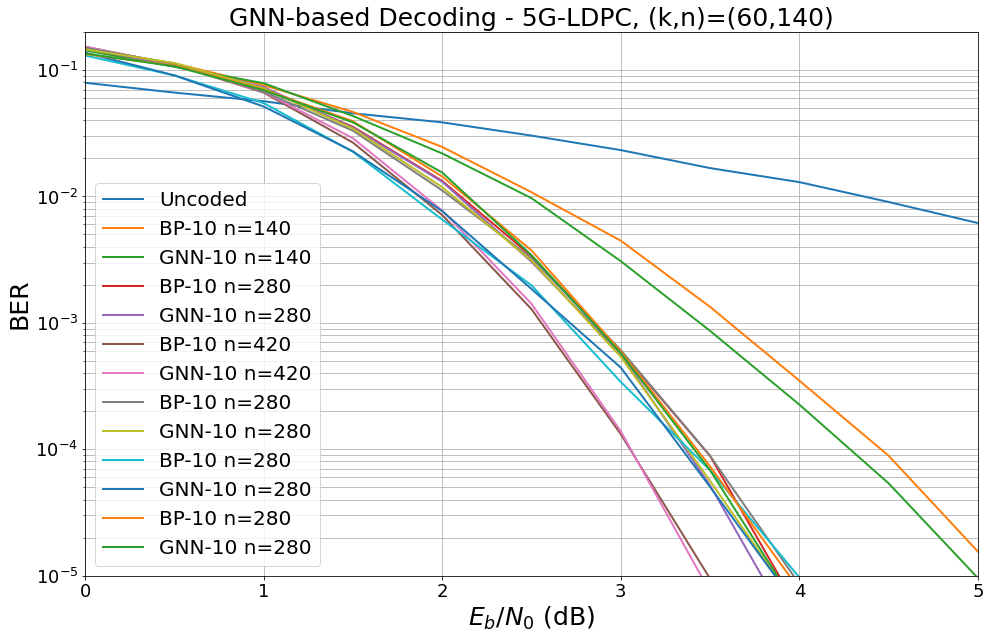

In [10]:
for idx, n_eval in enumerate(params["eval_ns"]):
    k_eval = params["eval_ks"][idx]
    
    # generate new code for each length
    encoder_5g_eval = LDPC5GEncoder(k_eval , n_eval)
    decoder_5g_eval = LDPC5GDecoder(encoder_5g_eval,
                                    num_iter=params["eval_num_iter"],
                                    return_infobits=params["return_infobits"])
    e2e_bp = E2EModel(encoder_5g_eval,
                      decoder_5g_eval,
                      k_eval,
                      n_eval,
                      return_infobits=params["return_infobits"],
                      es_no=params["sim_esno"] )

    ber_plot.simulate(e2e_bp,
                  ebno_dbs=ebno_dbs,
                  batch_size=params["mc_batch_size"],
                  num_target_block_errors=params["num_target_block_errors"],
                  legend=f"BP-{decoder_5g._num_iter.numpy()} n={n_eval}",
                  soft_estimates=True,
                  max_mc_iter=params["mc_iters"],
                  forward_keyboard_interrupt=False,
                  show_fig=False);
    # instantiate new decoder for each number of iter (otherwise no retracing)
    gnn_decoder_rm_eval = LDPC5GGNN(encoder_5g_eval,
                     num_embed_dims=params["num_embed_dims"],
                     num_msg_dims=params["num_msg_dims"],
                     num_hidden_units=params["num_hidden_units"],
                     num_mlp_layers=params["num_mlp_layers"],
                     num_iter=params["eval_num_iter"],
                     reduce_op=params["reduce_op"],
                     activation=params["activation"],
                     output_all_iter=False,
                     clip_llr_to=params["clip_llr_to"],
                     use_attributes=params["use_attributes"],
                     node_attribute_dims=params["node_attribute_dims"],
                     msg_attribute_dims=params["msg_attribute_dims"],
                     return_infobits=params["return_infobits"],
                     use_bias=params["use_bias"])    
    # generate new model   
    model = E2EModel(encoder_5g_eval,
                     gnn_decoder_rm_eval,
                     k_eval,
                     n_eval,
                     return_infobits=params["return_infobits"],
                     es_no=params["sim_esno"] )
    model(1,1.) # init model
    # copy weights from trained decoder
    model._decoder.set_weights(gnn_decoder.get_weights())

    # and run the BER simulations
    ber_plot.simulate(model,
                     ebno_dbs=ebno_dbs,
                     batch_size=params["mc_batch_size"],
                     num_target_block_errors=params["num_target_block_errors"],
                     legend=f"GNN-{model._decoder.num_iter} n={n_eval}",
                     soft_estimates=True,
                     max_mc_iter=params["mc_iters"],
                     forward_keyboard_interrupt=False,
                     show_fig=False);

ber_plot(xlim=[0, 5], ylim=[1e-5, 0.2]) # show final figure

**Remark**: This figures shows the results of Fig. 5a and Fig. 5b in the paper (Fig. 5a is plotted in the Es/N0 domain)

In [11]:
# save results for pgf plots
col_names = ["uncoded"]
for idx,n in enumerate(params["eval_ns"]):
    col_names.append("bp_k" + str(params["eval_ks"][idx]) + "_n" + str(n))
    col_names.append("gnn_k" + str(params["eval_ks"][idx]) + "_n" + str(n))
export_pgf(ber_plot, col_names)

snr, 	uncoded, 	bp_k60_n140, 	gnn_k60_n140, 	bp_k120_n280, 	gnn_k120_n280, 	bp_k180_n420, 	gnn_k180_n420, 	bp_k120_n280, 	gnn_k120_n280, 	bp_k90_n280, 	gnn_k90_n280, 	bp_k150_n280, 	gnn_k150_n280, 	
0.000,	7.932000E-02,	1.462500E-01,	1.432429E-01,	1.507964E-01,	1.475964E-01,	1.528595E-01,	1.531262E-01,	1.502607E-01,	1.459250E-01,	1.303679E-01,	1.374536E-01,	1.336464E-01,	1.351893E-01,	
0.500,	6.631000E-02,	1.130071E-01,	1.061214E-01,	1.109071E-01,	1.094250E-01,	1.102476E-01,	1.106286E-01,	1.121750E-01,	1.135393E-01,	9.065714E-02,	9.073571E-02,	1.084500E-01,	1.070714E-01,	
1.000,	5.667000E-02,	7.589286E-02,	7.871429E-02,	7.111786E-02,	7.333214E-02,	6.631667E-02,	6.715238E-02,	6.749286E-02,	7.168214E-02,	5.477857E-02,	5.145000E-02,	6.989286E-02,	6.931786E-02,	
1.500,	4.547000E-02,	4.659643E-02,	4.329643E-02,	3.555000E-02,	3.500179E-02,	2.665595E-02,	2.886190E-02,	3.310357E-02,	3.440357E-02,	2.257857E-02,	2.270893E-02,	3.936786E-02,	3.852143E-02,	
2.000,	3.856000E-02,	2.463333E-02,	2.1883